In [1]:
import pandas as pd
import numpy as np
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
import pingouin as pg
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Task 1

Retention is one of the most important metrics for the company. Your task is to write a function that calculates player retention (by days since player registration).

In [2]:
def retention(reg_path, auth_path, period_days=30):
    """
    Calculate user retention by registration month for specified period.
    
    Args:
        reg_path (str): Path to registration data CSV
        auth_path (str): Path to authentication data CSV
        period_days (int): Retention period in days (30)
    
    Returns:
        pd.DataFrame: Retention matrix with percentages (cohorts×days)
    """
    #EDA
    reg_data = pd.read_csv(reg_path, sep=';')
    auth_data = pd.read_csv(auth_path, sep=';')
    print(f"Reg data: {len(reg_data)} rows, {reg_data['uid'].nunique()} unique users")
    print(f"Auth data: {len(auth_data)} rows, {auth_data['uid'].nunique()} unique users")
    
    # Process data
    reg_data['reg_date'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
    auth_data['auth_date'] = pd.to_datetime(auth_data['auth_ts'], unit='s')
    
    merged_data = pd.merge(reg_data, auth_data, on='uid', how='left')
    merged_data['day'] = (merged_data['auth_date'] - merged_data['reg_date']).dt.days
    merged_data = merged_data[(merged_data['day'] >= 0) & (merged_data['day'] <= period_days)]
    merged_data['cohort'] = merged_data['reg_date'].dt.to_period('M')
    
    # Calculate retention
    cohort_size = merged_data.groupby('cohort')['uid'].nunique()
    retention = merged_data.groupby(['cohort', 'day'])['uid'].nunique().unstack()
    retention_rate = retention.div(cohort_size, axis=0) * 100
    
    # Return sample for better readability
    return retention_rate.round(1).tail(10)

In [3]:
# Example usage with sample output
retention_matrix = retention(
    '/mnt/HC_Volume_18315164/home-jupyter/jupyter-aleksej-mozgovoj-t-9ff39/shared/problem1-reg_data.csv',
    '/mnt/HC_Volume_18315164/home-jupyter/jupyter-aleksej-mozgovoj-t-9ff39/shared/problem1-auth_data.csv'
)
print("\nRetention matrix (sample):")
print(retention_matrix)

Reg data: 1000000 rows, 1000000 unique users
Auth data: 9601013 rows, 1000000 unique users

Retention matrix (sample):
day         0    1    2    3    4    5    6    7    8    9   ...   21   22  \
cohort                                                       ...             
2019-12  100.0  4.0  4.3  5.0  5.7  6.4  7.5  4.4  5.1  5.1  ...  3.7  3.9   
2020-01  100.0  4.1  4.3  5.0  5.5  6.3  7.2  4.4  4.9  5.1  ...  3.8  3.5   
2020-02  100.0  4.0  4.3  4.8  5.6  6.5  7.1  4.2  5.0  5.0  ...  3.7  3.6   
2020-03  100.0  4.1  4.2  5.0  5.6  6.2  7.5  4.4  5.0  5.2  ...  3.6  3.7   
2020-04  100.0  4.2  4.4  4.9  5.8  6.6  7.3  4.4  5.2  5.1  ...  3.9  3.8   
2020-05  100.0  3.9  4.3  4.9  5.8  6.3  7.3  4.5  4.9  5.2  ...  3.9  3.8   
2020-06  100.0  3.8  4.3  5.0  5.6  6.4  7.3  4.4  5.1  5.2  ...  3.7  3.8   
2020-07  100.0  4.1  4.4  5.0  5.7  6.5  7.2  4.6  5.0  5.1  ...  3.8  3.8   
2020-08  100.0  4.0  4.2  5.0  5.6  6.6  7.4  4.4  5.0  5.1  ...  3.9  3.7   
2020-09  100.0  3.9  3.

# Task 2

There are results from an A/B test where two user groups were offered different sets of promotional offers. It is known that ARPU in the test group is 5% higher than in the control group. However, in the control group, 1,928 out of 202,103 players were paying users, while in the test group, 1,805 out of 202,667 were paying.

Which set of offers should be considered better? What metrics should be analyzed to make the right decision, and how?

In [8]:
# Data uploading
df = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

# Hypothesis Formulation
print("""
Hypothesis Formulation:
H₀ (Null Hypothesis): There are no differences between the sentence sets in terms of key metrics.
H₁ (Alternative Hypothesis): There are statistically significant differences between the sentence sets.
""")


Hypothesis Formulation:
H₀ (Null Hypothesis): There are no differences between the sentence sets in terms of key metrics.
H₁ (Alternative Hypothesis): There are statistically significant differences between the sentence sets.



In [9]:
df = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')
df['log_revenue'] = np.log(df['revenue'] + 0.01)
df_paying = df.query('revenue > 0')

In [10]:
# Metrics calculation

metrics = df.groupby('testgroup', as_index = False).agg(cnt=('user_id', 'nunique'), revenue=('revenue', 'sum'))
metrics['ARPU'] = round(metrics['revenue'] / metrics['cnt'], 1)
metrics['paying_users'] = metrics['testgroup'].apply(lambda x: 1928 if x == 'a' else 1805)
metrics['ARPPU'] = round(metrics['revenue'] / metrics['paying_users'], 1)
metrics['CR'] = metrics['paying_users'] / metrics['cnt'] * 100

In [11]:
metrics

,testgroup,cnt,revenue,ARPU,paying_users,ARPPU,CR
0,a,202103,5136189,25.4,1928,2664.0,0.953969
1,b,202667,5421603,26.8,1805,3003.7,0.890624


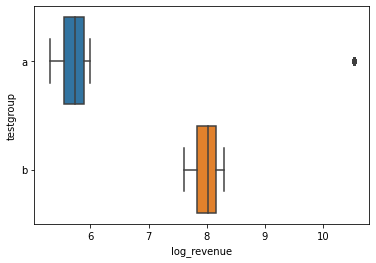

In [12]:
sns.boxplot(data = df_paying, x = 'log_revenue', y = 'testgroup')

In [13]:
#Bootstrap function

def bootstrap_test(group1, group2, metric_func, n_iter=10000):
    obs_diff = metric_func(group1) - metric_func(group2)
    combined = np.concatenate([group1, group2])
    bs_diffs = []
    
    for _ in range(n_iter):
        bs_sample = np.random.choice(combined, size=len(combined), replace=True)
        bs_diff = metric_func(bs_sample[:len(group1)]) - metric_func(bs_sample[len(group1):])
        bs_diffs.append(bs_diff)
    
    p_value = (np.abs(np.array(bs_diffs)) >= np.abs(obs_diff)).mean()
    return obs_diff, p_value

In [14]:
control = df[df['testgroup'] == 'a']
test = df[df['testgroup'] == 'b']

In [15]:
# ARPU test
arpu_diff, arpu_p = bootstrap_test(control['revenue'], test['revenue'], np.mean)
arpu_diff, arpu_p

(-1.3375668563128222, 0.5257)

In [16]:
# ARPPU test
arppu_diff, arppu_p = bootstrap_test(control[control['revenue'] > 0]['revenue'], 
                                    test[test['revenue'] > 0]['revenue'], np.mean)
arppu_diff, arppu_p

(-339.65972776174976, 0.1046)

In [17]:
# CR test
count = np.array([1928, 1805])  # paying users
nobs = np.array([202103, 202667])  # all users
cr_zstat, cr_p = proportions_ztest(count, nobs)

cr_zstat, cr_p

(2.108028495889841, 0.035028524642854865)

In [18]:
# Sample Size Check

print(f"Size of control group: {len(control)}")
print(f"Size of test group: {len(test)}")
print(f"Ratio: {len(control)/len(df):.1%} / {len(test)/len(df):.1%}")

Size of control group: 202103
Size of test group: 202667
Ratio: 49.9% / 50.1%


In [19]:
# Выводы
print("\nAnalysis Results:")
print(metrics)
print(f"\nStatistical Significance of Differences:")
print(f"ARPU: p-value = {arpu_p:.4f}")
print(f"ARPPU: p-value = {arppu_p:.4f}")
print(f"CR (z-test): p-value = {cr_p:.4f}")


Analysis Results:
  testgroup     cnt  revenue  ARPU  paying_users   ARPPU        CR
0         a  202103  5136189  25.4          1928  2664.0  0.953969
1         b  202667  5421603  26.8          1805  3003.7  0.890624

Statistical Significance of Differences:
ARPU: p-value = 0.5257
ARPPU: p-value = 0.1046
CR (z-test): p-value = 0.0350


Conclusions

To make an informed decision, the following key metrics should be considered:

ARPU: Higher in the test group, though the difference vs. control is not statistically significant.

ARPPU: Higher in the test group, but the difference is not statistically significant.

CR (Conversion Rate): Lower in the test group, with a statistically significant difference.

The control group exhibits outliers in high-revenue users (123 players)—this could indicate either data collection errors or the presence of key high-spending players. Further investigation of this user segment is required.

Risks of Adopting the Test Variant:
A decline in paying users (CR) may negatively impact long-term monetization.

The increase in ARPPU could be driven by a small number of high-value transactions.

Recommendations:
Reject the null hypothesis. The test variant should not be implemented, as the significant drop in CR outweighs the insignificant gains in ARPU/ARPPU.

To validate these findings, samples should be recollected, as the current groups exhibit substantial differences (non-overlapping user segments in terms of spending levels). Potential causes include split system errors.

# Task 3

In the game Plants & Gardens, limited-time thematic events are held every month. In these events, players can earn unique garden items, characters, extra coins, or bonuses. To receive rewards, players must complete a series of levels within a set time. What metrics can be used to evaluate the results of the latest event?

Suppose, in another event, we modified the mechanics so that after each failed attempt to complete a level, the player is rolled back several levels. Would the set of evaluation metrics change? If yes, how?

<p>To evaluate the results of the last completed event, the following metrics can be used:</p>

<h3>Growth metrics:</h3>
<ol>
  <li>Activation conversion rate (how many users started participating in the event)</li>
  <li>DAU (how the event affected user engagement in the game in terms of user numbers)</li>
  <li>Churn rate (how many players left the event)</li>
  <li>Event retention (how many players returned to the game to participate in the event)</li>
</ol>

<h3>Product metrics:</h3>
<ol start="5">
  <li>Event completion rate (how many users completed the event)</li>
  <li>Average session length for all users and for users who started the event (how the event affected user engagement in hours/minutes)</li>
</ol>

<p>If the event mechanics become more complex, the set of metrics will expand.</p>
<p>The following metrics will be added:</p>

<h3>Growth metrics:</h3>
<ol start="7">
  <li>Retention after failed attempt (what motivation level users have)</li>
</ol>

<h3>Product metrics:</h3>
<ol start="8">
  <li>Number of attempts to complete the nth level (which level is most difficult for players)</li>
</ol>